##XGBoost Model

The goal of this notebook is to train, tune, and evaluate the XGBoost model.

In [79]:
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
import shap

In [40]:
import pandas as pd
df = pd.read_csv("/content/final_modeling_dataset.csv")

In [41]:
df.head()

,Date,Close_SPY,High_SPY,Low_SPY,Open_SPY,Volume_SPY,Return_,Volatility_20_,Next_Return_,Label_,...,month,is_month_end,is_quarter_end,vader_neg,vader_neu,vader_pos,vader_compound,finbert_positive,finbert_negative,finbert_neutral
0,2018-03-14,243.689362,246.097046,243.131722,245.911166,105895100,-0.005132,0.009652,-0.001090,0,...,3,0,0,0.103,0.808,0.089,-0.5803,0.181511,0.009585,0.808904
1,2018-03-15,243.423782,244.848905,242.919225,244.202743,83433000,-0.001090,0.009262,0.001085,1,...,3,0,0,0.148,0.785,0.067,-0.9892,0.036360,0.896335,0.067304
2,2018-03-16,243.687820,244.745403,243.634499,243.954426,100343700,0.001085,0.008842,-0.013531,0,...,3,0,0,0.116,0.804,0.080,-0.8173,0.053502,0.652791,0.293707
3,2018-03-19,240.390579,243.865488,238.728672,242.932340,109208400,-0.013531,0.009379,0.001700,1,...,3,0,0,0.095,0.805,0.100,0.3025,0.040161,0.171686,0.788153
4,2018-03-20,240.799362,241.439243,240.115029,240.790466,59757300,0.001700,0.009279,-0.001919,0,...,3,0,0,0.114,0.805,0.081,-0.9849,0.035992,0.773770,0.190238


creating a holdout set/model training set

In [42]:
model_df = df.copy()
model_df = model_df.sort_index()
n = len(model_df)
holdout_size = int(n * 0.20)

model_df['split'] = 'train_val'
model_df.iloc[-holdout_size:, model_df.columns.get_loc('split')] = 'holdout'
model_df = model_df.drop(columns=["Date"], errors="ignore")

In [43]:
train_val = model_df[model_df['split'] == 'train_val']
holdout   = model_df[model_df['split'] == 'holdout']

Performing k-fold cross val to tune for best hyperparams for XGB

In [44]:
# classification target
y_train_val = train_val['Label_']
y_holdout   = holdout['Label_']

# drop targets + split column from features
X_train_val = train_val.drop(columns=['Label_', 'Next_Return_', 'split'])
X_holdout   = holdout.drop(columns=['Label_', 'Next_Return_', 'split'])

In [45]:
X_train_val.info()

<class 'pandas.core.frame.DataFrame'>
Index: 472 entries, 0 to 471
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Close_SPY          472 non-null    float64
 1   High_SPY           472 non-null    float64
 2   Low_SPY            472 non-null    float64
 3   Open_SPY           472 non-null    float64
 4   Volume_SPY         472 non-null    int64  
 5   Return_            472 non-null    float64
 6   Volatility_20_     472 non-null    float64
 7   High_Low_Spread    472 non-null    float64
 8   Close_Open_Change  472 non-null    float64
 9   MA_5               472 non-null    float64
 10  MA_20              472 non-null    float64
 11  MA_50              472 non-null    float64
 12  Return_5           472 non-null    float64
 13  Return_10          472 non-null    float64
 14  day_of_week        472 non-null    int64  
 15  month              472 non-null    int64  
 16  is_month_end       472 non-null

In [46]:
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

tscv = TimeSeriesSplit(n_splits=5)

xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_val), 1):
    X_tr, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
    y_tr, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]

    xgb.fit(X_tr, y_tr)

    # get predicted probabilities for the positive class
    y_val_proba = xgb.predict_proba(X_val)[:, 1]

    roc_auc = roc_auc_score(y_val, y_val_proba)
    print(f"Fold {fold} ROC-AUC: {roc_auc:.3f}")

Fold 1 ROC-AUC: 0.511
Fold 2 ROC-AUC: 0.469
Fold 3 ROC-AUC: 0.539
Fold 4 ROC-AUC: 0.457
Fold 5 ROC-AUC: 0.482


In [47]:
y_train_val.value_counts(normalize=True)

,proportion
Label_,
1,0.559322
0,0.440678


- baseline accuracy would be 55.9% if we were to guess 1 eveytime. we should use another metric to measure accuracy.

- accuracy hides directional sensitivity

In [48]:
param_grid = {
    'n_estimators': [300, 500, 800],
    'learning_rate': [0.01, 0.05],
    'max_depth': [2, 3, 4],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8],
}

In [49]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from xgboost import XGBClassifier

tscv = TimeSeriesSplit(n_splits=5)


neg = (y_train_val == 0).sum()
pos = (y_train_val == 1).sum()
scale_pos_weight = neg / pos

xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=tscv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train_val, y_train_val)

print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.7}
Best CV score: 0.4996617945563968


In [50]:
best_xgb = grid.best_estimator_

In [51]:
best_xgb

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

XGB on holdout set

In [54]:
best_xgb = grid.best_estimator_

y_hold_proba = best_xgb.predict_proba(X_holdout)[:, 1]
y_hold_pred = (y_hold_proba >= 0.5).astype(int)

print("Holdout ROC-AUC:", roc_auc_score(y_holdout, y_hold_proba))
print("Holdout Accuracy:", accuracy_score(y_holdout, y_hold_pred))

Holdout ROC-AUC: 0.508340649692713
Holdout Accuracy: 0.5084745762711864


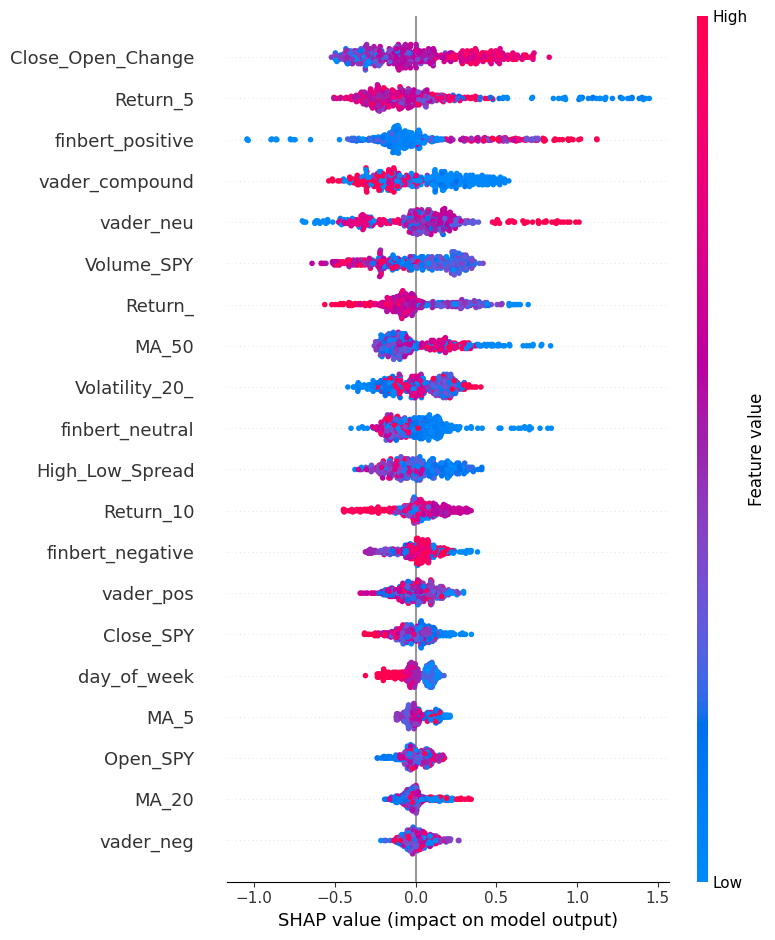

In [55]:
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_train_val)
shap.summary_plot(shap_values, X_train_val)

In [75]:
X_no_vader = X_train_val.drop(columns=[
    "vader_neg", "vader_neu", "vader_pos", "vader_compound"
])
X_no_vader.shape

(472, 21)

In [76]:
y_train_val.shape

(472,)

In [77]:
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

tscv = TimeSeriesSplit(n_splits=5)

xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_no_vader), 1):
    X_tr, X_val = X_no_vader.iloc[train_idx], X_no_vader.iloc[val_idx]
    y_tr, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]

    xgb.fit(X_tr, y_tr)

    # get predicted probabilities for the positive class
    y_val_proba = xgb.predict_proba(X_val)[:, 1]

    roc_auc = roc_auc_score(y_val, y_val_proba)
    print(f"Fold {fold} ROC-AUC: {roc_auc:.3f}")

Fold 1 ROC-AUC: 0.473
Fold 2 ROC-AUC: 0.497
Fold 3 ROC-AUC: 0.504
Fold 4 ROC-AUC: 0.450
Fold 5 ROC-AUC: 0.520


In [87]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from xgboost import XGBClassifier

tscv = TimeSeriesSplit(n_splits=5)


neg = (y_train_val == 0).sum()
pos = (y_train_val == 1).sum()
scale_pos_weight = neg / pos

xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=tscv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

grid.fit(X_no_vader, y_train_val)

print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.7}
Best CV score: 0.5015782753712191


In [88]:
best_xgb_2 = grid.best_estimator_

In [92]:
best_xgb_2 = grid.best_estimator_

drop_cols = ["vader_neg", "vader_neu", "vader_pos", "vader_compound"]
X_holdout_no_vader = X_holdout.drop(columns=drop_cols)

y_hold_proba = best_xgb_2.predict_proba(X_holdout_no_vader)[:, 1]
y_hold_pred = (y_hold_proba >= 0.5).astype(int)

print("Holdout ROC-AUC:", roc_auc_score(y_holdout, y_hold_proba))
print("Holdout Accuracy:", accuracy_score(y_holdout, y_hold_pred))

Holdout ROC-AUC: 0.5709686859818555
Holdout Accuracy: 0.559322033898305


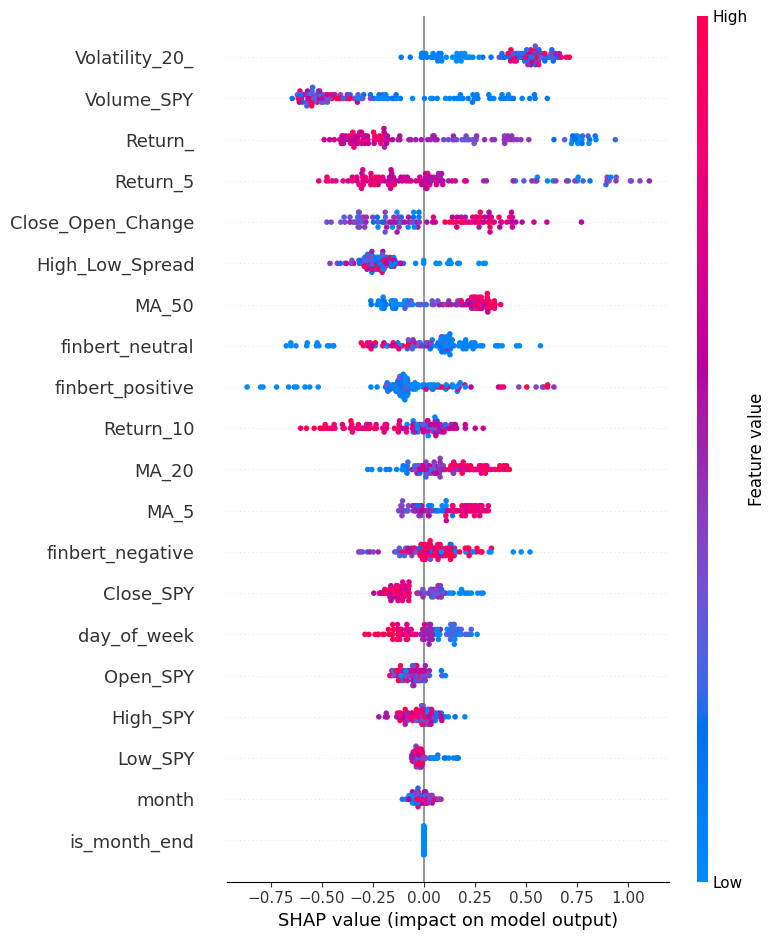

In [95]:
explainer = shap.TreeExplainer(best_xgb_2)
shap_values = explainer.shap_values(X_holdout_no_vader)
shap.summary_plot(shap_values, X_holdout_no_vader)